In [1]:

import numpy as np
import data_utils
import pickle
import matplotlib.pyplot as plt
import random
import networkx as nx
from sklearn.model_selection import cross_val_score
from sklearn import svm
import collections
import math
from functools import cmp_to_key


Exercise 1 Graphlet Kernel

In [2]:
with open('datasets/NCI1/data.pkl', 'rb') as f:
    graphs = pickle.load(f)

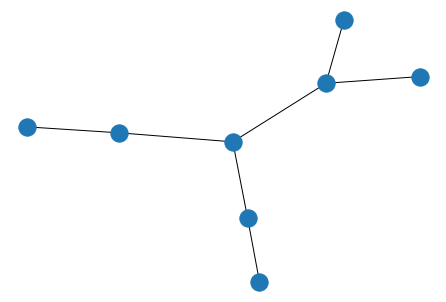

In [8]:
G1 = graphs[990]
nx.draw(G1)

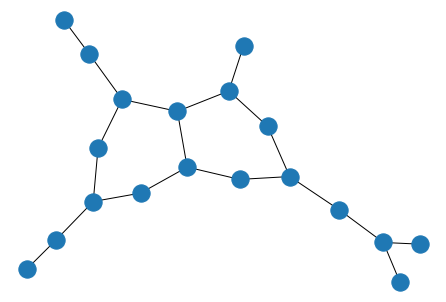

In [3]:
G2 = graphs[991]
nx.draw(G2)

In [4]:
def graphlet_list(k):
    """
    :param k: The size of graphlet
    :return graphlet_list: The graphlets of size k
    """
    assert k > 0
    atlas = nx.graph_atlas_g()[1:]
    graphlet_list = []
    for A in atlas:
        n = A.number_of_nodes()
        if n < k:
            continue
        if n > k:
            break
        graphlet_list.append(A)
    return graphlet_list

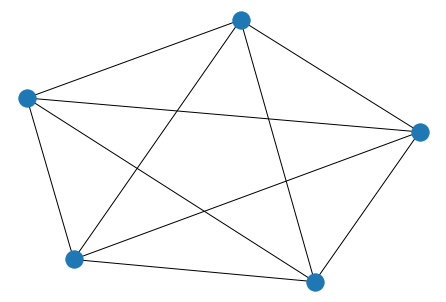

In [5]:
graphlets = graphlet_list(5)
nx.draw(graphlets[33])

In [6]:
def graphlet_features(G,g):

    """
    :param G: A newtorkx graph
    :param g: Graphlets of size k=5
    :return graphlet_count: The frequency of the occurence of all 34 graphlets in the sample subgraph S
    """
    
    graphlet_count = np.zeros(34)
    
    for i in range(1000):
        S = G.subgraph(list(random.sample(G.nodes(),5)))

        for j in range(len(g)):
            if nx.is_isomorphic(S,graphlets[j]) == True:
                graphlet_count[j] += 1

    return graphlet_count

In [9]:
feature_G1 = graphlet_features(G1,graphlets)
feature_G2 = graphlet_features(G2,graphlets)

<ipython-input-6-9b347b4df266>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  S = G.subgraph(list(random.sample(G.nodes(),5)))


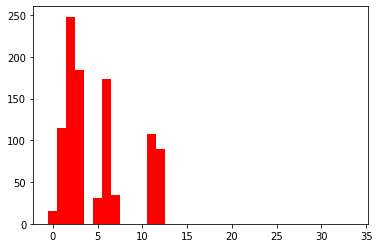

In [10]:
pos = np.arange(34)
width = 1.0    
plt.bar(pos, feature_G1, width, color='r')
plt.show()



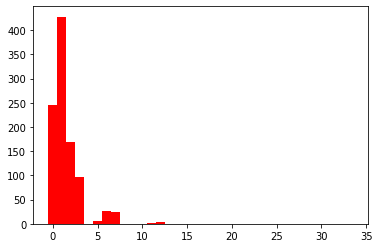

In [11]:
plt.bar(pos, feature_G2, width, color='r')
plt.show()


In [12]:
graph_kernel = np.dot(feature_G1,feature_G2)
graph_kernel


118608.0

Exercise 2 Closed Walk

In [13]:

def closedwalk(G, walklength):

    #computing adjacency matrix for graph G
    A = data_utils.get_adjacency_matrix(G)

    #computing degree of each node in G
    D = np.diag(np.sum(A, axis=0))

    #computing inverse of Degree Matrix by checking for singular matrix
    D_inverse = np.linalg.inv(D) if np.linalg.det(D) else np.linalg.pinv(D)

    #Transitional Matrix containing probabilities for each node to each of its neighbouring node A/D
    T = np.dot(D_inverse,A)

    num_of_nodes = G.number_of_nodes()
    walks = np.empty((0, walklength+1), int)

    #computing random walks for given walklength for each node in the graph
    for node in range(num_of_nodes):
        p = np.array([0]*num_of_nodes).reshape(-1,1)
        p[node] = 1
        walk = list() 
        walk = [node] 
        for k in range(walklength):
            p = np.dot(T,p)
            walk.append(np.argmax(p))
        walks = np.append(walks, np.array([walk]), axis=0)
    closedwalk = np.zeros(walklength)
    
    #computing closed walk for different lengths upto walklength
    for i in range(1,walklength):
        closedwalk[i] = closedwalk[i-1]
        for j in range(len(walks)):
            if(walks[j][i] == j):
                closedwalk[i] += 1
    return closedwalk

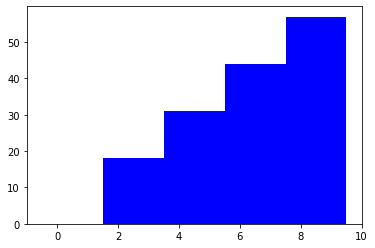

In [14]:
G = graphs[0]

walklength = 10
closedwalk = closedwalk(G, walklength)

x = np.arange(walklength)
plt.bar(x, closedwalk, width, color='b')
plt.show()

EXERCISE 3 - WL-KERNEL

In [23]:

def create_list(n):
       q = [*range(1,n,1)]
       return q


""" Function to aggregate neighboring color labels  """
def aggregate_colors(G,node_labels):
    """
    :param G: A networkx graph.
    :param node_labels: The node labels assigned to the graphs as colors. 
    :return agg: A dictionary with keys as the nodes and values as concatenated strings of the node labels of        neighborhood nodes.
    """
     
    agg = dict()
    for k in range(len(node_labels)):
        agg[k+1] = [str(node_labels[k+1])]
        a = sorted([dict(G.nodes())[n]['node_label'] for n in G.neighbors(list(dict(G.nodes()).keys())[k])])
        agg[k+1] = ''.join(agg[k+1] + [str(i) for i in a])

    return agg

def wl_graph_features(r, feature_len):
    """
    :param r: A dictionary with keys as the colors and values as their corresponding frequency in the graphs          after refinement.
    :feature_len: The length of the feature vector of the graph obatined after color refinement. (No. of colors)
    :return wl_features: The feature vectors obtained after color refinement on a graph.
    """
    z = np.zeros(feature_len+1)
    e = dict(enumerate(z,start=1))
    for k in e:
        for key in r:
            if k == key:
                e[k] = r[key]
    wl_features = np.array(list(e.values()))
    return wl_features


In [24]:
def wlkernel(G, G1, feature_len):
    """
    :param G,G1: Two networkx graphs.
    :param feature_len: Length of the feature vectors (no. of colors).
    :return wl1,wl2: Weisfeiler-Lehman graph feature vectors of G1,G2.
    """

    """Get the node labels of input graphs"""
    try:
        data_utils.get_node_labels(G)
        data_utils.get_node_labels(G1) 

    except:
        labels_G = create_list(len(G)+1)
        labels_G1 =create_list(len(G1)+1)

        nx.set_node_attributes(G, dict.fromkeys(labels_G, 1), name='label')
        node_labels_G = nx.get_node_attributes(G,'label')
        

        nx.set_node_attributes(G1, dict.fromkeys(labels_G1, 1), name='label')
        node_labels_G1 = nx.get_node_attributes(G1,'label')

    else :
        node_labels_G = dict(enumerate(data_utils.get_node_labels(G), 1))
        node_labels_G1 = dict(enumerate(data_utils.get_node_labels(G1), 1))

    """ Initialize colors as the node labels of the input graphs """
    colors_G = []
    colors_G.extend(list(node_labels_G.values()))

    colors_G1 = []
    colors_G1.extend(list(node_labels_G1.values()))

    """ Aggregate the node labels(colors) of neighboring nodes for every node in the graph """
    agg_colors_G = aggregate_colors(G,node_labels_G)

    agg_colors_G1 = aggregate_colors(G1,node_labels_G1)

    """ Create a hashtable of all unique aggregated node labels"""
    t = list(dict(collections.Counter(sorted(list(map(int, list(agg_colors_G.values()) + list(agg_colors_G1.values())))))).keys())
    
    """ Removing duplicate values"""

    for i in range(len(t)):
        for j in range(i + 1, len(t)-1):
            if sorted(list((map(str,t)))[i]) == sorted(list((map(str,t)))[j]):
                t.pop(j)   
    
    l_start = len(list(collections.Counter(colors_G+colors_G1).keys()))+1

    """ Hash table tt for mapping aggregate labels to new node labels"""
    tt = dict(enumerate(t,l_start))

    """ Assigns new node label value from tt """
    for k in tt:
        for key in agg_colors_G:
            if agg_colors_G[key] == str(tt[k]):
                node_labels_G[key] = k


    for k in tt:
        for key in agg_colors_G1:
            if agg_colors_G1[key] == str(tt[k]):
                node_labels_G1[key] = k

    """ Add the newly obtained node labels to colors """
    colors_G.extend(list(node_labels_G.values()))
    colors_G1.extend(list(node_labels_G1.values()))

    """One iteration complete"""

    """ Again aggregate the node labels of neighboring nodes in second iteration """
    agg_colors_G = aggregate_colors(G,node_labels_G)
    agg_colors_G1 = aggregate_colors(G1,node_labels_G1)

    """ Adding unique aggregated node labels to p """
    p = list(dict(collections.Counter(sorted(list(map(int, list(agg_colors_G.values()) + list(agg_colors_G1.values())))))).keys())

    """ Checking for duplicate values within p and comparing with previously obtained list t """
    for i in range(len(p)):
        for j in range(i + 1, len(p)-1):
            if sorted(list((map(str,p)))[i]) == sorted(list((map(str,p)))[j]):
                p.pop(j) 

    try:
        for i in range(len(p)):
            for j in range(len(t)-1):
                if sorted(list((map(str,p)))[i]) == sorted(list((map(str,t)))[j]):
                    p.pop(i)      

    except:
        pass

    else:
        for i in range(len(p)):
            for j in range(len(t)-1):
                if sorted(list((map(str,p)))[i]) == sorted(list((map(str,t)))[j]):
                    p.pop(i)      

    """ Creating new hash table of all obtained aggregated node labels"""
    pp = dict(enumerate(p,list(tt.keys())[-1]+1))
    new_dict = {**tt, **pp}

    new_dict = dict(enumerate(sorted(list(new_dict.values())),l_start))

    """ Assigning new node label values from hash table new_dict  """
    for k in new_dict:
        for key in agg_colors_G:
            if agg_colors_G[key] == str(new_dict[k]):
                node_labels_G[key] = k

    for k in new_dict:
        for key in agg_colors_G1:
            if agg_colors_G1[key] == str(new_dict[k]):
                node_labels_G1[key] = k
    
    """ Again adding the new nodel labels to the existing colors """
    colors_G.extend(list(node_labels_G.values()))
    colors_G1.extend(list(node_labels_G1.values()))

    """ Computing the frequency of all colors in the graphs  """ 
    color_freq1 = collections.Counter(sorted(colors_G))
    color_freq2 = collections.Counter(sorted(colors_G1))

    r1 = dict(color_freq1)
    r2 = dict(color_freq2)

    """ Finally obtaining the feature vectors of the graphs """
    wl1 = wl_graph_features(r1, feature_len)
    wl2 = wl_graph_features(r2, feature_len)
    
    return wl1,wl2

IndentationError: unexpected indent (<ipython-input-24-011a61cc5d88>, line 36)

In [ ]:
#Test Code
with open('datasets/NCI1/data.pkl', 'rb') as f:
    graphs = pickle.load(f)
G = graphs[4]
G1 = graphs[7]
wl1, wl2 = wlkernel(G,G1, len(G)+len(G1))
print(wl1, wl2)

[ 7.  2. 19.  1.  5.  0.  2.  1.  7.  1.  4.  2.  2.  2.  1.  3.  2.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  2.  2.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.] [ 0.  2. 16.  1.  0.  1.  0.  1.  0.  2. 14.  1.  0.  0.  0.  0.  3.  1.
  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.
  0.  0.  0.  0.]


EXERCISE 4 - SVM

In [19]:
with open('datasets/NCI1/data.pkl', 'rb') as f:
    nci1 = pickle.load(f)
with open('datasets/ENZYMES/data.pkl', 'rb') as f:
    dd = pickle.load(f)
with open('datasets/NCI1/data.pkl', 'rb') as f:
    enzymes = pickle.load(f)

In [6]:
#Computing Gram Matrix
def GramMatrix(X1, X2):
    """(Pre)calculates Gram Matrix K"""

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            #dot product of feature vectors
            gram_matrix[i, j] = np.dot(x1,x2)
    return gram_matrix

Graphlet Kernel

In [ ]:
#NCI1 Dataset
target_nci1 = list()
for G in nci1:
    #as we randomly sample a subgraph of length 5, so graph should have atleast 5 or more nodes
    if(G.number_of_nodes()>=5):
        target_nci1.append(data_utils.get_graph_label(G))
graphlets = graphlet_list(5)
descriptive_nci1 = list()
for G in nci1:
    if(G.number_of_nodes()>=5):
        descriptive_nci1.append(graphlet_features(G,graphlets))

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_nci1), np.array(descriptive_nci1)), target_nci1, cv=10)
scores

array([0.57420925, 0.65450122, 0.66666667, 0.61313869, 0.55717762,
       0.59854015, 0.66423358, 0.67396594, 0.58394161, 0.63902439])

In [ ]:
#DD Dataset
target_dd = list()
for G in dd:
    if(G.number_of_nodes()>=5):
        target_dd.append(data_utils.get_graph_label(G))
graphlets = graphlet_list(5)
descriptive_dd = list()
for G in dd:
    if(G.number_of_nodes()>=5):
        descriptive_dd.append(graphlet_features(G,graphlets))

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_dd), np.array(descriptive_dd)), target_dd, cv=10)
scores

array([0.28333333, 0.11666667, 0.31666667, 0.23333333, 0.18333333,
       0.25      , 0.3       , 0.27118644, 0.22033898, 0.15254237])

In [ ]:
#ENZYMES Dataset
target_enzymes = list()
for G in enzymes:
    if(G.number_of_nodes()>=5):
        target_enzymes.append(data_utils.get_graph_label(G))
graphlets = graphlet_list(5)
descriptive_enzymes = list()
for G in enzymes:
    if(G.number_of_nodes()>=5):
        descriptive_enzymes.append(graphlet_features(G,graphlets))

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_enzymes), np.array(descriptive_enzymes)), target_enzymes, cv=10)
scores

Closed Walk

In [ ]:
#NCI1 Dataset
walklength = 15
target_nci1 = list()
for G in nci1:
    target_nci1.append(data_utils.get_graph_label(G))
descriptive_nci1 = list()
for G in nci1:
    descriptive_nci1.append(closedwalk(G,walklength))

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_nci1), np.array(descriptive_nci1)), target_nci1, cv=10)
scores

array([0.60827251, 0.68613139, 0.61800487, 0.62773723, 0.60583942,
       0.63990268, 0.69099757, 0.67153285, 0.63260341, 0.67639903])

In [ ]:
#DD Dataset
walklength = 10
target_dd = list()
for G in dd:
    target_dd.append(data_utils.get_graph_label(G))
descriptive_dd = list()
for G in dd:
    descriptive_dd.append(closedwalk(G,walklength))

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_dd), np.array(descriptive_dd)), target_dd, cv=10)
scores

array([0.23333333, 0.21666667, 0.31666667, 0.26666667, 0.16666667,
       0.23333333, 0.21666667, 0.25      , 0.18333333, 0.16666667])

In [ ]:
#ENZYMES Dataset
walklength = 10
target_enzymes = list()
for G in enzymes:
    target_enzymes.append(data_utils.get_graph_label(G))
descriptive_enzymes = list()
for G in enzymes:
    descriptive_enzymes.append(closedwalk(G,walklength))

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_enzymes), np.array(descriptive_enzymes)), target_enzymes, cv=10)
scores

array([0.60583942, 0.66423358, 0.62043796, 0.62530414, 0.59124088,
       0.63260341, 0.66666667, 0.64963504, 0.65450122, 0.66666667])

WL-Kernel

In [7]:
#NCI1 Dataset
target_nci1 = list()
def compare(x, y):
    return len(x) - len(y)
sorted_graphs = sorted(nci1, key=cmp_to_key(compare), reverse=True)
#fixing the feature length of all graphs in dataset by taking the length of 2 largest graphs and adding their number of nodes
feature_len = sum(map(len, sorted_graphs[0:2]))

largest_graph = sorted_graphs[0]
for G in nci1:
    target_nci1.append(data_utils.get_graph_label(G))
descriptive_nci1 = list()
for G in nci1:
    descriptive_nci1.append(wlkernel(G,largest_graph, feature_len)[0])
clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_nci1), np.array(descriptive_nci1)), target_nci1, cv=10)
scores

array([0.62043796, 0.65693431, 0.69829684, 0.63990268, 0.62530414,
       0.6350365 , 0.70316302, 0.68613139, 0.66423358, 0.66909976])

In [17]:
#DD Dataset
target_dd = list()
def compare(x, y):
    return len(x) - len(y)
sorted_graphs = sorted(dd, key=cmp_to_key(compare), reverse=True)
feature_len = sum(map(len, sorted_graphs[0:2]))

largest_graph = sorted_graphs[0]
target_dd = list()
for G in dd:
    target_dd.append(data_utils.get_graph_label(G))
descriptive_dd = list()
for G in dd:
    descriptive_dd.append(wlkernel(G,largest_graph, feature_len)[0])

clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_dd), np.array(descriptive_dd)), target_dd, cv=10)
scores

IndexError: ignored

In [19]:
#ENZYMES Dataset
target_dd = list()
def compare(x, y):
    return len(x) - len(y)
sorted_graphs = sorted(enzymes, key=cmp_to_key(compare), reverse=True)
feature_len = sum(map(len, sorted_graphs[0:2]))

largest_graph = sorted_graphs[0]
target_enzymes= list()
for G in enzymes:
    target_enzymes.append(data_utils.get_graph_label(G))
descriptive_enzymes = list()
for G in enzymes:
    descriptive_enzymes.append(wlkernel(G,largest_graph, feature_len)[0])
clf = svm.SVC(kernel="precomputed")
scores = cross_val_score(clf, GramMatrix(np.array(descriptive_enzymes), np.array(descriptive_enzymes)), target_enzymes, cv=10)
scores

array([0.62043796, 0.65693431, 0.69829684, 0.63990268, 0.62530414,
       0.6350365 , 0.70316302, 0.68613139, 0.66423358, 0.66909976])